# Part3: Machine Learning
team member: Shaoying Zheng, Xiao Pu, Zhongrui Ning

## 0: Merge Dividend Yield Data with Company Data
[This dataset](https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide) provides around 10,000 records of the largest companies worldwide. For a job-seeker, Dividend Yield is a key metric to consider when evaluating a company. Dividend Yield is the ratio of the annual dividend per share to the current price per share. So if a job-seeker is offered shares as part of their compensation, they would want to know the Dividend Yield of the company.

In [3]:
import pandas as pd
from fuzzywuzzy import fuzz

/opt/miniconda3/envs/si618/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
company_df = pd.read_csv('Projectdata/Companies_ranked_by_Dividend_Yield.csv')
company_df.head()

In [ ]:
job_df = pd.read_csv('Projectdata/job_company_pair.csv')
# randomly select 5 name from job_df
job_df['name'].sample(5)

In [ ]:
# create a new df that only contains company name in job_df
job_df_name = job_df['name'].unique()
job_df_name = pd.DataFrame(job_df_name,columns=['company_name'])
job_df_name.head(5)

Since the two dataset are from different sources, we will match the company names using following steps:
1. Remove special characters and spaces from the company names in both datasets.
2. Convert the company names to lowercase.
3. Use the `fuzzywuzzy` library to match the company names.
4. If the match score is above a certain threshold, we will consider the two company names to be the same. We will create a new column called `is_top` in the `job_df` dataset to store if there is a match in the `company_df` dataset.
5. If `is_top` is False, check if the company name in the `job_df` dataset is a substring of any company name in the `company_df` dataset and vice versa. If it is, we will consider the two company names to be the same and change `is_top` to True.
6. If `is_top` is True, we will merge the relevant columns from the `company_df` dataset to the `job_df` dataset.

In [ ]:
import re
def clean_company_name(name):
    """
    Clean company name by:
    1. Removing special characters and spaces
    2. Converting to lowercase
    """
    # Convert to string in case of non-string input
    name = str(name)
    
    # Remove special characters and convert to lowercase
    cleaned_name = re.sub(r'[^a-zA-Z0-9]', '', name).lower()
    
    return cleaned_name

In [ ]:
def find_longest_substring(s1, s2):
    """
    Find the longest consecutive substring between two strings
    """
    # Remove non-alphanumeric characters
    s1 = re.sub(r'[^a-z0-9]', '', s1)
    s2 = re.sub(r'[^a-z0-9]', '', s2)
    
    # Find all consecutive substrings of at least 6 characters
    for length in range(min(len(s1), len(s2)), 5, -1):
        for i in range(len(s1) - length + 1):
            substring = s1[i:i+length]
            if substring in s2:
                return substring
    
    return None

In [ ]:
def match_company_names(job_df, company_df, match_threshold=80):
    """
    Match company names between job and company datasets
    
    Parameters:
    - job_df: DataFrame with job listings
    - company_df: DataFrame with company information
    - match_threshold: Fuzzy matching threshold (default 80)
    
    Returns:
    - Updated job_df with new columns
    """
    # Create copies to avoid modifying original dataframes
    job_df = job_df.copy()
    company_df = company_df.copy()
    
    job_df['cleaned_company_name'] = job_df['company_name'].apply(clean_company_name)
    company_df['cleaned_company_name'] = company_df['Name'].apply(clean_company_name)
    
    # Create a dictionary of company names for faster lookup
    company_dict = {row['cleaned_company_name']: row for _, row in company_df.iterrows()}
    
    def find_best_match(job_company):
        # Exact match
        if job_company in company_dict:
            return True, company_dict[job_company]
        
        # Fuzzy and substring matching
        best_match = None
        best_score = 0
        
        for company_name, company_info in company_dict.items():
            # Fuzzy ratio match
            ratio = fuzz.ratio(job_company, company_name)
            
            # Substring match bonus
            substring_bonus = (job_company in company_name or company_name in job_company)
            
            # Calculate score with substring bonus
            score = ratio + (20 if substring_bonus else 0)
            
            if score > best_score and score >= match_threshold:
                best_score = score
                best_match = company_info
        
        return best_match is not None, best_match
    
    # Vectorized matching
    results = job_df['cleaned_company_name'].apply(find_best_match)
    
    # Update DataFrame
    job_df['is_top'] = results.apply(lambda x: x[0])
    
    # Merge additional company information for matched companies
    def merge_company_info(row, matched_result):
        if matched_result[0]:
            # Merge relevant columns from company_df
            company_info = matched_result[1]
            columns_to_merge = ['dividend_yield_ttm','price (GBP)']
            for col in columns_to_merge:
                if col in company_df.columns and col not in job_df.columns:
                    row[col] = company_info[col]
        return row
    
    # Apply merging
    job_df = job_df.apply(lambda row: merge_company_info(row, 
                                       results.loc[row.name]), 
                           axis=1)
    
    # Optional: Drop the temporary cleaning column
    
    return job_df

In [ ]:
matched_job_df = match_company_names(job_df_name, company_df)
matched_job_df.sort_values('is_top', ascending=False).head(5)
matched_job_df.to_csv('Projectdata/matched_companies.csv', index=False)

In [ ]:
# Merge the matched job listings with the original job listings
job_company_df = pd.read_csv('Projectdata/job_company_pair.csv')
job_company_df['cleaned_company_name'] = job_company_df['name'].apply(clean_company_name)
job_company_df = pd.merge(job_company_df, matched_job_df, how='left', on='cleaned_company_name')
job_company_df.head(5)

In [ ]:
job_company_df.drop(columns=['cleaned_company_name','name'], inplace=True)
job_company_df.to_csv('Projectdata/matched_job_company_pair.csv', index=False)

## Preprocessing Data (80 points)

1. Import the dataset you have chosen based on your earlier assignments.
2. Clean your dataset, handling missing values, inconsistencies, and any other issues you encounter.  You should be able to reuse code from earlier work to help you do this, although you may need to make some modifications.
3. Apply various preprocessing techniques such as feature scaling, one-hot encoding, handling categorical variables, and dimensionality reduction.
4. Justify the preprocessing choices made, ensuring that they align with the analytical techniques you plan to use later.

In [6]:
# Load the matched job listings and check missing values
job_company_df = pd.read_csv('Projectdata/matched_job_company_pair.csv')
job_company_df.isnull().sum()

job_id                          0
company_id                      0
skill_abr                       0
skill_name                      0
industry_id                     0
max_salary                  48190
med_salary                 260360
min_salary                  48190
pay_period                      0
industry_name                  41
company_size                 5532
country                         0
employee_count                  0
follower_count                  0
employee_follower_ratio         4
annual_min_salary               0
annual_max_salary               0
annual_med_salary               0
skill_category                  0
company_name                    0
dividend_yield_ttm         170707
is_top                          0
price (GBP)                170707
dtype: int64

`max_salary`, `min_salary` and `med_salary` all have missing values because they are not available for all job postings. Also, `pay_period` is inconsistent because for different posting it may have different pay period. In project part I, we converted all salaries into annual salaries, and filled missing (min, max) or median salary based on the other column(s). 

There might be a mismatch between `pay_period` here and the actual pay period. And that will cause the salary to be incorrect. So, we set $ 7540 as the threshold for annual salary. If the salary is below this threshold, we will consider it as incorrect and remove it.

In [7]:
# drop max_salary, med_salary and min_salary columns
job_company_df.drop(columns=['max_salary','med_salary','min_salary', 'pay_period'], inplace=True)

# Keep only rows with annual_min_salary > 7540
job_company_df = job_company_df[job_company_df['annual_min_salary'] > 7540]

In [8]:
# drop if industry_name is null, fill missing values in dividend_yield_ttm and price (GBP) with 0
job_company_df.dropna(subset=['industry_name'], inplace=True)
job_company_df.fillna({'dividend_yield_ttm': 0, 'price (GBP)': 0}, inplace=True)

In [9]:
# fill missing values in employee_follower_ratio with 0
job_company_df.fillna({'employee_follower_ratio': 0}, inplace=True)

In [10]:
# Sample 5 rows from missing company_size
job_company_df[job_company_df['company_size'].isnull()].sample(5)

,job_id,company_id,skill_abr,skill_name,industry_id,industry_name,company_size,country,employee_count,follower_count,employee_follower_ratio,annual_min_salary,annual_max_salary,annual_med_salary,skill_category,company_name,dividend_yield_ttm,is_top,price (GBP)
299953,3904954875,14803700.0,IT,Information Technology,4,Software Development,NaN,GB,3,14294,0.000210,150000.0,190000.0,158000.0,Other,Orbit Recruitment Group,0.000,False,0.00000
288074,3902866871,12907420.0,ENG,Engineering,7,Semiconductor Manufacturing,NaN,US,6,1417,0.004234,165000.0,180000.0,168000.0,Technical & Engineering,VivaHire,0.000,False,0.00000
139156,3886217072,77586042.0,MRKT,Marketing,17,Medical Equipment Manufacturing,NaN,US,1,1162,0.000861,50000.0,70000.0,54000.0,Creative,Talient Solutions,118.475,True,20.39005
267131,3905257175,91652182.0,LGL,Legal,24,Computers and Electronics Manufacturing,NaN,US,25,2983,0.008381,130000.0,700000.0,244000.0,Legal & Compliance,Haraka Headhunters,0.000,False,0.00000
274563,3901350004,76345004.0,FIN,Finance,4,Software Development,NaN,US,5,271,0.018450,50000.0,80000.0,56000.0,Finance,TaxPlanIQ (SaaS tax planning for accountants),0.000,False,0.00000


We can see it's highly likely that a posting with a missing company_size is a posting from a recruiter. So we will check if the company itself's posting is in this dataset. We will check if there is another job with same skill_abr and annual_med_salary; if so, we will drop this row.

In [13]:
# Identify rows with missing company size
missing_company_size = job_company_df[job_company_df['company_size'].isna()]

# Create a list to store indices of rows to drop
rows_to_drop = []

# Iterate through rows with missing company size
for idx, row in missing_company_size.iterrows():
    # Find potential matching jobs based on skill_abr, industry_id, and annual_med_salary
    matching_jobs = job_company_df[
        (job_company_df['skill_abr'] == row['skill_abr']) & 
        (job_company_df['annual_med_salary'] == row['annual_med_salary']) & 
        (job_company_df['company_size'].notna())
    ]
    
    # If a matching job exists, mark this row for dropping
    if not matching_jobs.empty:
        rows_to_drop.append(idx)

print(f"Rows to drop: {len(rows_to_drop)}")

Rows to drop: 4519


In [14]:
job_company_df.drop(index=rows_to_drop, inplace=True)

In [15]:
# For other missing values in company_size, fill with 0 since we assume they are small companies
job_company_df.fillna({'company_size': 0}, inplace=True)

In [17]:
job_company_df.isnull().sum()

job_id                     0
company_id                 0
skill_abr                  0
skill_name                 0
industry_id                0
industry_name              0
company_size               0
country                    0
employee_count             0
follower_count             0
employee_follower_ratio    0
annual_min_salary          0
annual_max_salary          0
annual_med_salary          0
skill_category             0
company_name               0
dividend_yield_ttm         0
is_top                     0
price (GBP)                0
dtype: int64

In [16]:
# job_company_df.to_csv('Projectdata/cleaned_job_company_pair.csv', index=False)

Before scaling, we want to:

1. Remove `employee_count` and `follower_count` because they may cause multicollinearity with `company_size` and `employee_follower_ratio`.
2. Focus our data on U.S. companies only.

In [2]:
job_df = pd.read_csv('Projectdata/cleaned_job_company_pair.csv')

In [3]:
job_df.drop(columns=['employee_count','follower_count'], inplace=True)

# only keep rows with country == 'US'
job_df = job_df[job_df['country'] == 'US']

NLP on text columns:

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [21]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [22]:
def vectorize_and_reduce_text(df, text_columns, vectorization_method='tfidf', 
                               reduction_method='pca', n_components=10):

    for col in text_columns:
        col_text = df[col].apply(preprocess_text)
        # combine all text columns
        if col == text_columns[0]:
            df['preprocessed_text'] = col_text
        else:
            df['preprocessed_text'] = df['preprocessed_text'] + ' ' + col_text
    
    # Vectorization
    if vectorization_method == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=1000)
    else:  # count vectorization
        vectorizer = CountVectorizer(max_features=1000)
    
    # Fit and transform text to vector
    text_vectors = vectorizer.fit_transform(df['preprocessed_text'])
    
    # Dimensionality Reduction
    if reduction_method == 'pca':
        reducer = PCA(n_components=n_components)
        # Standardize first for PCA
        text_vectors_scaled = StandardScaler().fit_transform(text_vectors.toarray())
        reduced_vectors = reducer.fit_transform(text_vectors_scaled)
    else:  # Truncated SVD (works well with sparse matrices)
        reducer = TruncatedSVD(n_components=n_components)
        reduced_vectors = reducer.fit_transform(text_vectors)
    
    # Create DataFrame with reduced vectors
    reduced_df = pd.DataFrame(
        reduced_vectors, 
        columns=[f'{reduction_method}_text_component_{i+1}' for i in range(n_components)]
    )
    
    # Combine original DataFrame with reduced text features
    result_df = pd.concat([df, reduced_df], axis=1)
    
    return result_df, reducer, vectorizer

In [ ]:
# job_df_vector,_,_ = vectorize_and_reduce_text(job_df, ['skill_name','industry_name','company_name'], n_components=5)

In [24]:
job_df_vector.head(5)

,job_id,company_id,skill_abr,skill_name,industry_id,industry_name,company_size,country,employee_follower_ratio,annual_min_salary,...,company_name,dividend_yield_ttm,is_top,price (GBP),preprocessed_text,pca_text_component_1,pca_text_component_2,pca_text_component_3,pca_text_component_4,pca_text_component_5
0,921716,2774458.0,MRKT,Marketing,44,Real Estate,2,US,0.170991,35360.0,...,Corcoran Sawyer Smith,0.0,False,0.0,marketing real estate corcoran sawyer smith,-0.368512,0.227145,-0.454321,0.115129,-0.182726
1,921716,2774458.0,SALE,Sales,44,Real Estate,2,US,0.170991,35360.0,...,Corcoran Sawyer Smith,0.0,False,0.0,sales real estate corcoran sawyer smith,-0.379216,0.213018,-0.443585,0.106975,-0.189599
2,10998357,64896719.0,MNFC,Manufacturing,32,Restaurants,1,US,0.375000,45000.0,...,The National Exemplar,0.0,False,0.0,manufacturing restaurants national exemplar,-1.019100,3.282573,2.395577,0.102374,0.123930
3,10998357,64896719.0,MGMT,Management,32,Restaurants,1,US,0.375000,45000.0,...,The National Exemplar,0.0,False,0.0,management restaurants national exemplar,-1.000771,3.228462,2.445832,0.061840,0.209240
4,3899530060,64896719.0,MNFC,Manufacturing,32,Restaurants,1,US,0.375000,55000.0,...,The National Exemplar,0.0,False,0.0,manufacturing restaurants national exemplar,-1.019100,3.282573,2.395577,0.102374,0.123930


In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import gensim
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
class WordEmbeddingVectorizer:
    def __init__(self, embedding_type='word2vec', vector_size=300):
        """
        Initialize word embedding vectorizer
        
        Parameters:
        embedding_type (str): Type of word embedding 
            Options: 'word2vec', 'glove', 'fasttext'
        vector_size (int): Dimension of word vectors
        """
        self.embedding_type = embedding_type
        self.vector_size = vector_size
        self.model = self._load_embedding_model()
        self.stop_words = set(stopwords.words('english'))
    
    def _load_embedding_model(self):
        """
        Load pre-trained word embedding model
        """
        try:
            # Mapping of user-friendly names to gensim downloader names
            embedding_map = {
                'word2vec': 'word2vec-google-news-300',
                'glove': 'glove-wiki-gigaword-300',
                'fasttext': 'fasttext-wiki-news-subwords-300'
            }
            
            model_name = embedding_map.get(self.embedding_type, 'word2vec-google-news-300')
            print(f"Loading {self.embedding_type} embedding model...")
            return api.load(model_name)
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
    
    def preprocess_text(self, text):
        """
        Preprocess text for embedding
        
        Parameters:
        text (str): Input text
        
        Returns:
        list: Preprocessed tokens
        """
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and very short words
        tokens = [token for token in tokens 
                  if token not in self.stop_words and len(token) > 2]
        
        return tokens
    
    def text_to_vector(self, text, method='mean'):

        # Preprocess text
        tokens = self.preprocess_text(text)
        
        # Get word vectors
        word_vectors = []
        for token in tokens:
            try:
                # Get vector for each word in the model's vocabulary
                word_vectors.append(self.model[token])
            except KeyError:
                # Skip words not in the vocabulary
                continue
        
        # Handle empty vector case
        if not word_vectors:
            return np.zeros(self.vector_size)
        
        # Aggregate word vectors
        if method == 'mean':
            return np.mean(word_vectors, axis=0)
        else:
            return np.sum(word_vectors, axis=0)
    
    def vectorize_dataframe(self, df, text_columns, n_components=10):
        # vectorize every column
        for col in text_columns:
            df[col+'_vector'] = df[col].apply(self.text_to_vector)
            # convert to matrix
            embedding_matrix = np.vstack(df[col+'_vector'])
            # scale the matrix
            embedding_matrix = StandardScaler().fit_transform(embedding_matrix)
            # apply PCA
            pca = PCA(n_components=n_components)
            pca_result = pca.fit_transform(embedding_matrix)
            # create a new dataframe
            pca_df = pd.DataFrame(pca_result, columns=[f'{col}_pca_{i+1}' for i in range(n_components)])
            # combine the original dataframe with the pca dataframe
            df = pd.concat([df, pca_df], axis=1)
        return df, pca

In [5]:
vectorizer = WordEmbeddingVectorizer(embedding_type='word2vec')
job_df_vector, _ = vectorizer.vectorize_dataframe(job_df, ['skill_name','industry_name'], n_components=3)

Loading word2vec embedding model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
job_df_vector.head(5)

,job_id,company_id,skill_abr,skill_name,industry_id,industry_name,company_size,country,employee_follower_ratio,annual_min_salary,...,is_top,price (GBP),skill_name_vector,skill_name_pca_1,skill_name_pca_2,skill_name_pca_3,industry_name_vector,industry_name_pca_1,industry_name_pca_2,industry_name_pca_3
0,921716,2774458.0,MRKT,Marketing,44,Real Estate,2,US,0.170991,35360.0,...,False,0.0,"[0.18261719, -0.140625, -0.20410156, -0.136718...",3.080973,4.344913,-5.374780,"[0.23144531, 0.0847168, -0.12597656, 0.0641937...",-1.405619,1.455760,-1.803953
1,921716,2774458.0,SALE,Sales,44,Real Estate,2,US,0.170991,35360.0,...,False,0.0,"[0.35742188, -0.110839844, -0.07763672, 0.0834...",13.946016,10.726450,-0.201688,"[0.23144531, 0.0847168, -0.12597656, 0.0641937...",-1.405619,1.455760,-1.803953
2,10998357,64896719.0,MNFC,Manufacturing,32,Restaurants,1,US,0.375000,45000.0,...,False,0.0,"[0.045166016, -0.013183594, 0.059326172, -0.00...",14.697279,-10.739057,1.994149,"[-0.104003906, -0.037841797, 0.08203125, 0.496...",0.782815,3.055054,1.834806
3,10998357,64896719.0,MGMT,Management,32,Restaurants,1,US,0.375000,45000.0,...,False,0.0,"[-0.15332031, 0.103515625, -0.08984375, -0.094...",-5.345903,2.975295,-9.018609,"[-0.104003906, -0.037841797, 0.08203125, 0.496...",0.782815,3.055054,1.834806
4,3899530060,64896719.0,MNFC,Manufacturing,32,Restaurants,1,US,0.375000,55000.0,...,False,0.0,"[0.045166016, -0.013183594, 0.059326172, -0.00...",14.697279,-10.739057,1.994149,"[-0.104003906, -0.037841797, 0.08203125, 0.496...",0.782815,3.055054,1.834806


In [8]:
# delete two vector columns
job_df_vector.drop(columns=['skill_name_vector','industry_name_vector'], inplace=True)

In [9]:
job_df_vector.to_csv('Projectdata/job_data_vectorized_word2vec.csv', index=False)

# Clustering/Classification Analysis 
- Clearly define your analytical goal and the rationale behind choosing either clustering or classification.
- If clustering:
1. Implement k-Means and Agglomerative clustering techniques.
2. Experiment with different numbers of clusters and identify the most appropriate number for your dataset.
3. Interpret and analyze the resulting clusters and discuss insights you've gained from them.
- If classification:
1. Choose and implement at least two different classifiers.
2. Optimize parameters for each classifier and evaluate their performance using appropriate metrics.
3. Interpret and analyze the classification results, discussing the comparative effectiveness of the classifiers used.


## Goals：
1. Build tuned machine learning models to find out how features in that dataset affect wage levels and classify jobs based on feature values.
2. Generate job recommendations for each individual through clustering algorithms based on natural language processing models

### 1. Build Machine learning model

In [2]:
# Find the top jobs based on tuned machine learning models
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('Projectdata/job_data_vectorized_word2vec.csv')

features = [
    'skill_name_pca_1', 'skill_name_pca_2', 'skill_name_pca_3',
    'industry_name_pca_1', 'industry_name_pca_2', 'industry_name_pca_3',
    'company_size', 'employee_follower_ratio'
]

X = data[features]
y = data['is_top'].astype(int)  # Convert boolean to integer for classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# tune Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

logreg_grid = GridSearchCV(logreg, logreg_params, cv=3, scoring='accuracy', n_jobs=-1)
logreg_grid.fit(X_train, y_train)

# best logistic regression model
best_logreg = logreg_grid.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

# tune Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30], 
    'min_samples_split': [2, 5, 10] 
}

rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# best_rf
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# estimate models
logreg_report = classification_report(y_test, y_pred_logreg)
rf_report = classification_report(y_test, y_pred_rf)

{
    "Best Logistic Regression Params": logreg_grid.best_params_,
    "Logistic Regression Accuracy": accuracy_score(y_test, y_pred_logreg),
    "Logistic Regression Report": logreg_report,
    "Best Random Forest Params": rf_grid.best_params_,
    "Random Forest Accuracy": accuracy_score(y_test, y_pred_rf),
    "Random Forest Report": rf_report
}

/home/codespace/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'Best Logistic Regression Params': {'C': 10, 'solver': 'liblinear'},
 'Logistic Regression Accuracy': 0.6895729890764647,
 'Logistic Regression Report': '              precision    recall  f1-score   support\n\n           0       0.73      0.68      0.71     43753\n           1       0.65      0.70      0.67     36807\n\n    accuracy                           0.69     80560\n   macro avg       0.69      0.69      0.69     80560\nweighted avg       0.69      0.69      0.69     80560\n',
 'Best Random Forest Params': {'max_depth': 30,
  'min_samples_split': 2,
  'n_estimators': 100},
 'Random Forest Accuracy': 0.9856007944389275,
 'Random Forest Report': '              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.99     43753\n           1       0.99      0.98      0.98     36807\n\n    accuracy                           0.99     80560\n   macro avg       0.99      0.99      0.99     80560\nweighted avg       0.99      0.99      0.99     80560\n'}

### Finding out how features in this dataset effect the salary level

employee_follower_ratio    0.534467
company_size               0.154036
industry_name_pca_2        0.079864
industry_name_pca_1        0.079669
industry_name_pca_3        0.071398
skill_name_pca_2           0.026899
skill_name_pca_1           0.026890
skill_name_pca_3           0.026777
dtype: float64


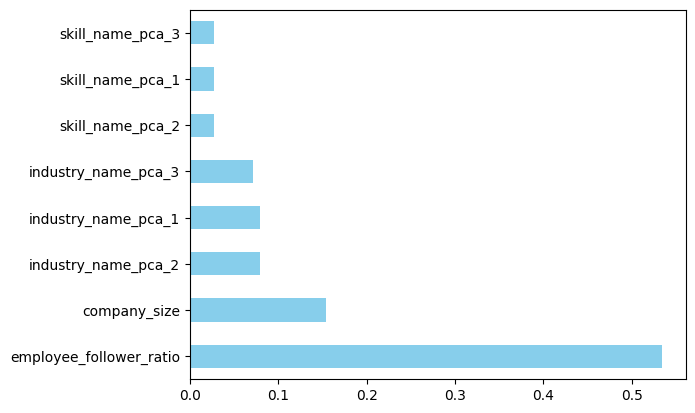

In [3]:
# using the best model to predict the top jobs
best_rf.predict(X_test)
# finding out how feature importance
best_rf.feature_importances_
# visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(best_rf.feature_importances_, index=features)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)
feature_importance.plot(kind='barh', color='skyblue')
plt.show()

### 2. Generate job recommendations for each individual through clustering algorithms based on natural language processing models